Saving BDM_PROJ_Invoiced_Dispatch_Materials_CY_24.xlsx to BDM_PROJ_Invoiced_Dispatch_Materials_CY_24 (3).xlsx
Saving BDM_PROJECT_CT_24.xlsx to BDM_PROJECT_CT_24 (3).xlsx


/tmp/ipython-input-4-3270364922.py:18: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  invoice_df['Inv Date'] = pd.to_datetime(invoice_df['Inv Date'], errors='coerce')
/tmp/ipython-input-4-3270364922.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


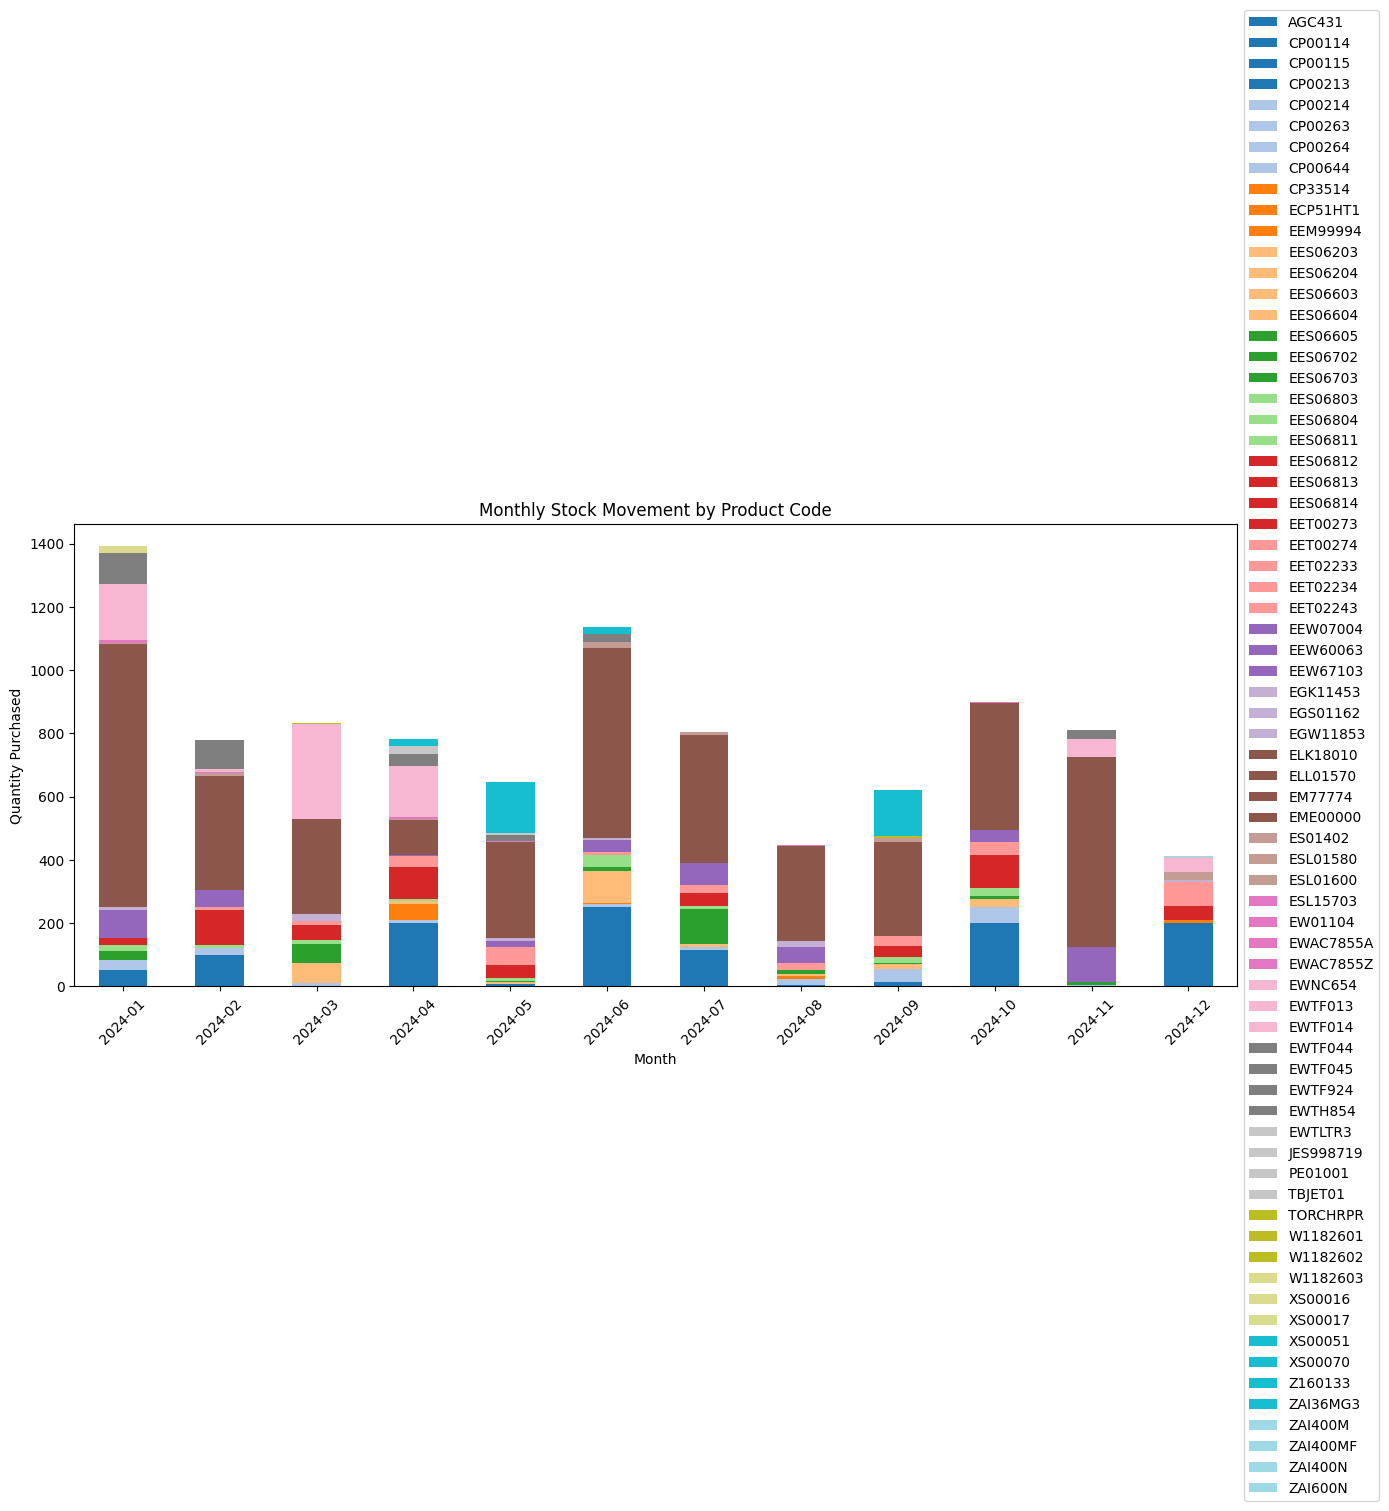

/tmp/ipython-input-4-3270364922.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


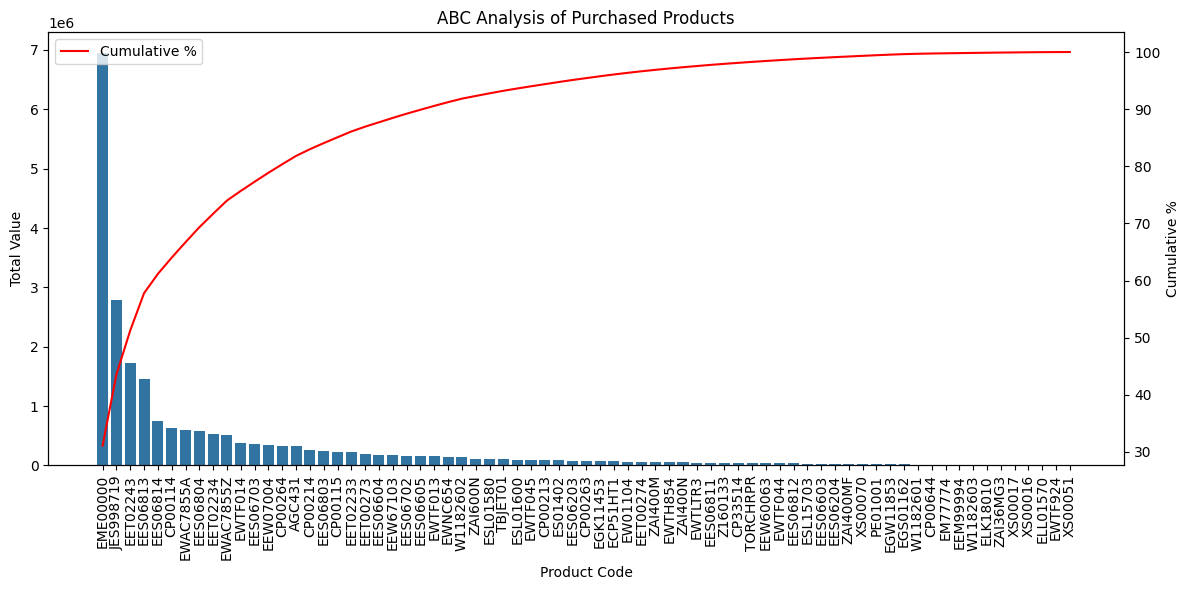

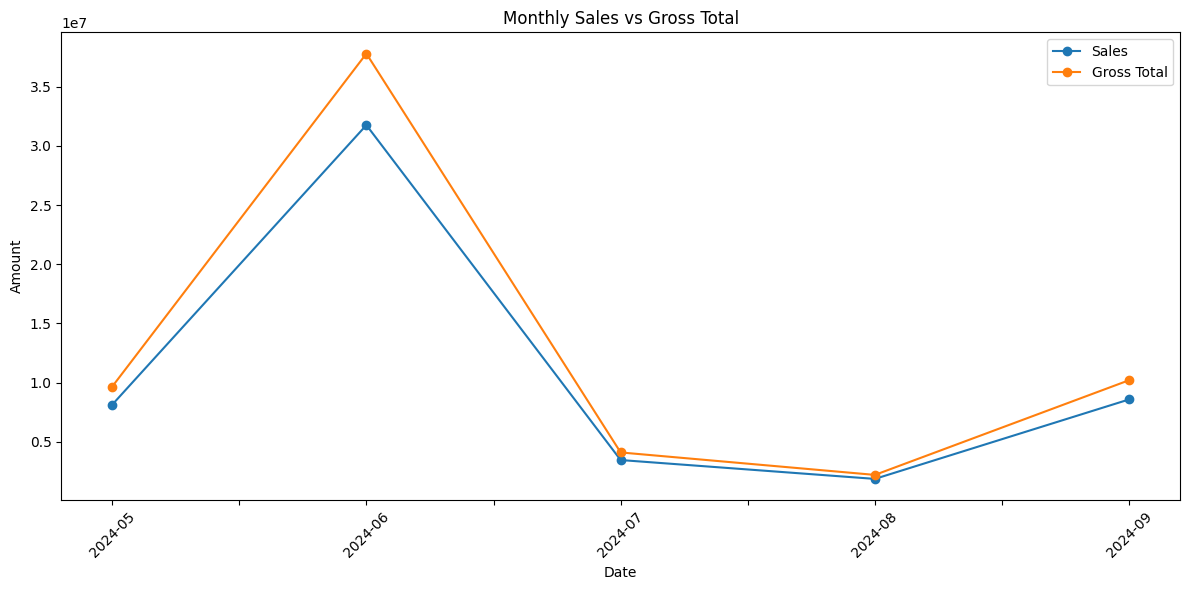

Top 10 Customers by Outstanding Amount:


,Buyer,Sales,Collection,Outstanding,% Recovered
92,Yeoman Marine Services Private Limited,10823964.0,2076036.0,8747928.0,19.179997
43,Mangalamurti Transport,6615522.0,1268793.0,5346729.0,19.179031
42,MR. VIVEK LAHANU VIDHATE,6125190.0,1174810.0,4950380.0,19.179976
28,JENIL SYNDICATE,3477880.3,630036.7,2847843.6,18.115537
32,KRUSHNA CRANE SERVICES,3062595.0,587405.0,2475190.0,19.179976
7,Baswaraj Jagannath Patil,1845947.0,354053.0,1491894.0,19.180020
0,ADITYA CRANE SERVICE,1803994.0,346006.0,1457988.0,19.179997
75,Shree Sai Enterprises,1803994.0,346006.0,1457988.0,19.179997
84,UNITECH STEEL STRUCTURES,1762041.0,337959.0,1424082.0,19.179974
39,MANGALMURTI ENTERPRISES,1678134.0,321866.0,1356268.0,19.179994


/tmp/ipython-input-4-3270364922.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Buyer', y='Outstanding', data=customer_summary.head(10), palette='Reds_r')


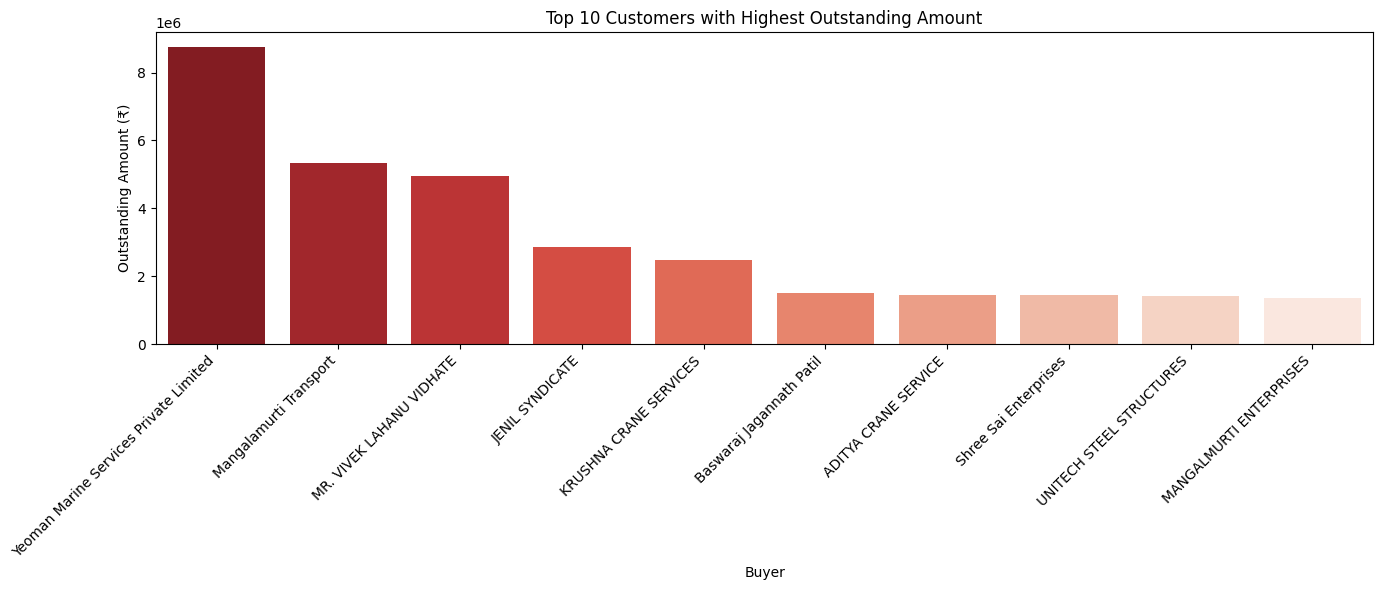

In [ ]:
# STEP 1: Install required libraries
!pip install pandas openpyxl matplotlib seaborn

# STEP 2: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# STEP 3: Upload the two Excel files
uploaded = files.upload()

# STEP 4: Load the Excel files
invoice_df = pd.read_excel("BDM_PROJ_Invoiced_Dispatch_Materials_CY_24.xlsx")
sales_df = pd.read_excel("BDM_PROJECT_CT_24.xlsx")

# STEP 5: Clean and preprocess Invoice (Purchase) Data
invoice_df['Inv Date'] = pd.to_datetime(invoice_df['Inv Date'], errors='coerce')
invoice_df['Total Value'] = invoice_df['Qty'] * invoice_df['Rate']

# -------------------------------
# 📦 ANALYSIS 1: Stock Movement & Consumption Analysis
# -------------------------------
stock_summary = invoice_df.groupby(['Product Code', invoice_df['Inv Date'].dt.to_period('M')])['Qty'].sum().unstack(fill_value=0)

stock_summary.T.plot(kind='bar', stacked=True, figsize=(15, 6), colormap='tab20')
plt.title("Monthly Stock Movement by Product Code")
plt.xlabel("Month")
plt.ylabel("Quantity Purchased")
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

# -------------------------------
# 📦 ANALYSIS 2: ABC Analysis
# -------------------------------
abc_df = invoice_df.groupby('Product Code')['Total Value'].sum().sort_values(ascending=False).reset_index()
abc_df['Cumulative %'] = 100 * abc_df['Total Value'].cumsum() / abc_df['Total Value'].sum()

# ABC categorization
def classify(p):
    if p <= 70:
        return 'A'
    elif p <= 90:
        return 'B'
    else:
        return 'C'

abc_df['Category'] = abc_df['Cumulative %'].apply(classify)

# ABC Pareto Chart
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.barplot(x='Product Code', y='Total Value', data=abc_df, ax=ax1)
ax1.set_ylabel("Total Value")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax2 = ax1.twinx()
sns.lineplot(x='Product Code', y='Cumulative %', data=abc_df, ax=ax2, color='red', label='Cumulative %')
ax2.set_ylabel("Cumulative %")
plt.title("ABC Analysis of Purchased Products")
plt.tight_layout()
plt.show()

# -------------------------------
# 💰 ANALYSIS 3: Sales vs Collection Trend
# -------------------------------

# Clean and rename for Sales Data
sales_df['Date'] = pd.to_datetime(sales_df['Date'], errors='coerce')
sales_df.rename(columns={'Value': 'Sales'}, inplace=True)  # 'Collection' column already named correctly in previous file

# Fill missing Collection column if it's not present
if 'Collection' not in sales_df.columns:
    sales_df['Collection'] = sales_df['Gross Total']  # Or leave it 0 if unknown

# Group by month
sales_summary = sales_df.groupby(sales_df['Date'].dt.to_period('M'))[['Sales', 'Gross Total']].sum().reset_index()
sales_summary['Date'] = sales_summary['Date'].astype(str)

# Line Plot: Sales vs Collection
sales_summary.plot(x='Date', y=['Sales', 'Gross Total'], kind='line', marker='o', figsize=(12, 6))
plt.title("Monthly Sales vs Gross Total")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# 💰 ANALYSIS 4: Collection Efficiency Ratio
# -------------------------------

# Group by Buyer
customer_summary = sales_df.groupby('Buyer')[['Sales', 'Collection']].sum().reset_index()
customer_summary['Outstanding'] = customer_summary['Sales'] - customer_summary['Collection']
customer_summary['% Recovered'] = 100 * customer_summary['Collection'] / customer_summary['Sales']

# Sort by Outstanding amount (descending)
customer_summary = customer_summary.sort_values(by='Outstanding', ascending=False)

# Display Top 10 customers with most pending payments
print("Top 10 Customers by Outstanding Amount:")
display(customer_summary.head(10))

# Plot
plt.figure(figsize=(14,6))
sns.barplot(x='Buyer', y='Outstanding', data=customer_summary.head(10), palette='Reds_r')
plt.title("Top 10 Customers with Highest Outstanding Amount")
plt.ylabel("Outstanding Amount (₹)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

